In [1]:
!nvidia-smi

Thu Mar 18 17:12:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import tqdm

In [29]:
class PCB_Env:

    def __init__(self, size_h, size_w):
        self.field = None
        self.agent_position = None
        self.target_position = None
        self.size_h = size_h
        self.size_w = size_w
        self.standing_still = 0

    def check(self, x1, y1, x2, y2):
        grid_check = self.size_w > x2 >= 0 and self.size_h > y2 >= 0
        cross_check = True
        if grid_check:
            x1, x2 = min(x1, x2), max(x1, x2)
            y1, y2 = min(y1, y2), max(y1, y2)
            cross_check_x = 1 not in self.field[y1:y2,x1+1:x2+1]
            cross_check_y = 1 not in self.field[y1+1:y2+1,x1:x2]
            cross_check = cross_check_x and cross_check_y
        return grid_check and cross_check

    def step_y(self, n: int):
        x, y = self.agent_position
        if self.check(x, y, x, y + n):
            self.field[min(y+n, y):max(y+n, y), x] = 1
            self.field[y][x] = 1
            self.agent_position = (x, y + n)
            return True
        else:
            return False

    def step_x(self, n: int):
        x, y = self.agent_position
        if self.check(x, y, x + n, y):
            self.field[y][min(x+n, x):max(x+n, x)] = 1
            self.field[y][x] = 1
            self.agent_position = (x + n, y)
            return True
        else:
            return False

    def calculate_reward(self, x1, y1, x2, y2):
        dst1 = math.hypot(self.target_position[0] - x1,
                          self.target_position[1] - y1)
        dst2 = math.hypot(self.target_position[0] - x2,
                          self.target_position[1] - y2)
        return (dst1 - dst2) * 0.2

    def step(self, dx: int, dy: int):
        dx, dy = int(dx), int(dy) # TODO: мб стоит делать по-другому
        start_field = self.field.copy()
        x1, y1 = self.agent_position
        rx, ry = self.step_x(dx), self.step_y(dy)
        if not (rx and ry) or dx == dy == 0:
            reward = -1
            self.standing_still += 1
            self.field = start_field
            self.agent_position = (x1, y1)
            return self.field, reward, False, self.standing_still
        x2, y2 = self.agent_position
        self.field[y2][x2] = 2
        done = self.agent_position == self.target_position
        reward = self.calculate_reward(x1, y1, x2, y2)
        self.standing_still = 0
        if done:
            reward = 10
        return self.field, reward, done, self.standing_still

    def reset(self, start_x, start_y, end_x, end_y):
        self.field = np.zeros((self.size_h, self.size_w))
        self.field[start_y][start_x] = 2
        self.field[end_y][end_x] = 3
        self.agent_position = (start_x, start_y)
        self.target_position = (end_x, end_y)
        self.standing_still = 0
        return self.field

    def render(self):
        plt.imshow(self.field)
        plt.draw()
        plt.pause(0.0001)

0.2828427124746199 False 0
-1 False 1
4.059674628357125 False 0
1.1297888715441908 False 0
1.1714246050157897 False 0
-1 False 1
-1.2785495002819127 False 0
10 True 0


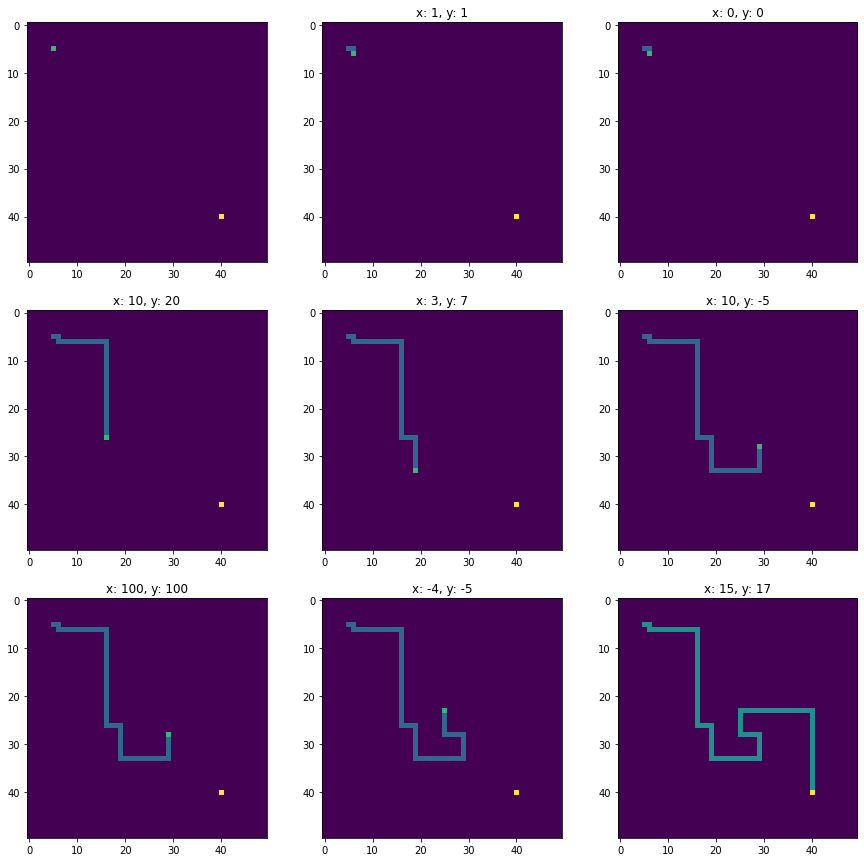

In [30]:
steps = [[1, 1], [0, 0], [10, 20], [3, 7], 
         [10, -5], [100, 100], [-4, -5], [15, 17]]
env = PCB_Env(50, 50)

state = env.reset(5, 5, 40, 40)
fig, axs = plt.subplots(len(steps) // 3 + 1, 3, figsize=(15, 15))
axs = axs.flatten()
axs[0].imshow(state)

for (x, y), ax in zip(steps, axs[1:]):
  state, reward, done, ss = env.step(x, y)
  print(reward, done, ss)
  ax.imshow(state)
  ax.set_title(f"x: {x}, y: {y}")

In [31]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory():

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [48]:
BATCH_SIZE = 64
GAMMA = 0.009
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 100
TARGET_UPDATE = 7
SIZE_H, SIZE_W = 50, 50


ENV = PCB_Env(size_h=SIZE_H, size_w=SIZE_W)

# target_actor, policy_actor, target_critic, policy_critic

def select_action(state, steps_done, policy_actor):
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    if sample > eps_threshold:
        with torch.no_grad():
            dx, dy = policy_actor(state)[0]
            return [dx, dy]
    else:
        dx = torch.tensor(random.randint(-SIZE_H, SIZE_H), device=device)
        dy = torch.tensor(random.randint(-SIZE_W, SIZE_W), device=device)
        return [dx, dy]


In [55]:
class Critic(nn.Module):

    def __init__(self, h, w):
        super(Critic, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.fc1 = nn.Linear(h * w + 2, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x, a):
        x = x.to(self.device, dtype=torch.float)
        a = a.to(self.device, dtype=torch.float)
        x = x.reshape((x.shape[0], x.shape[1] * x.shape[2]))
        x = torch.cat((x, a), 1).to(self.device, dtype=torch.float)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class Actor(nn.Module):

    def __init__(self, h, w):
        super(Actor, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.fc1 = nn.Linear(h * w, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 2)

    def forward(self, x):
        x = x.to(self.device, dtype=torch.float)
        x = x.reshape((x.shape[0], x.shape[1] * x.shape[2]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = torch.tanh(x) * max(SIZE_H, SIZE_W)
        return x

In [56]:
def optimize_critic(target_actor, policy_actor, 
                    target_critic, policy_critic, 
                    optimizer):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, 
                                  dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    # action_batch = torch.cat(batch.action)
    action_batch = torch.tensor(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_critic(state_batch, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    prediction = target_actor(non_final_next_states)
    next_state_values[non_final_mask] = torch.squeeze(
        target_critic(non_final_next_states, prediction)).detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values.float(), 
                            expected_state_action_values.unsqueeze(1).float())

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_critic.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    return loss.item()


def optimize_actor(target_actor, policy_actor, 
                   target_critic, policy_critic, 
                   optimizer):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    state_batch = torch.cat(batch.state)
    actions_pred = policy_actor(state_batch)
    loss = -policy_critic(state_batch, actions_pred).mean()

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()


def update_target(policy_net, target_net):
    upd_dict = dict()
    policy_state_dict = policy_net.state_dict()
    target_state_dict = target_net.state_dict()
    for key, value in policy_state_dict.items():
        upd_dict[key] = value * (1 - 1 / TARGET_UPDATE) + target_state_dict[key] / TARGET_UPDATE
    target_net.load_state_dict(upd_dict)
    return target_net

In [57]:
policy_critic = Critic(SIZE_H, SIZE_W).to(device)
target_critic = Critic(SIZE_H, SIZE_W).to(device)
policy_actor = Actor(SIZE_H, SIZE_W).to(device)
target_actor = Actor(SIZE_H, SIZE_W).to(device)

target_critic.load_state_dict(policy_critic.state_dict())
target_critic.eval()
target_actor.load_state_dict(policy_actor.state_dict())
target_actor.eval()

optimizer_critic = optim.Adam(policy_critic.parameters())
optimizer_actor = optim.Adam(policy_actor.parameters())

In [ ]:
steps_done = 0

result = list()
losses_actor = list()
losses_critic = list()
heatmaps = list()
heatmap = np.zeros((SIZE_H, SIZE_W))
episodes_till_done = list()

num_done_episodes = 20
i_episode = 0
done_episodes = 0
done_counter = 0
bar = tqdm.notebook.tqdm(total=num_done_episodes)

start_x, end_x = random.sample(range(50), 2)
start_y, end_y = random.sample(range(50), 2)
memory = ReplayMemory(5000)

while done_episodes < num_done_episodes:
    i_episode += 1
    # Initialize the environment and state
    state = ENV.reset(start_x, start_y, end_x, end_y) / 3
    state = torch.from_numpy(state).unsqueeze(0).to(device)
    total_reward = 0
    total_loss_actor = 0
    total_loss_critic = 0
    for t in count():
        # Select and perform an action
        dx, dy = select_action(state, steps_done, policy_actor)
        bar.set_postfix({'dx': dx.item(), 'dy': dy.item()})
        steps_done += 1
        next_state, reward, done, ss = ENV.step(dx.item(), dy.item())
        next_state = torch.from_numpy(next_state / 3).unsqueeze(0).to(device)
        total_reward += reward
        reward = torch.tensor([reward], device=device)

        # Observe new state
        if done:
            done_counter += 1
            if done_counter == 10:
              episodes_till_done.append(i_episode)
              bar.update()
              done_episodes += 1
              heatmaps.append(heatmap)
              heatmap = np.zeros((SIZE_H, SIZE_W))
              start_x, end_x = random.sample(range(50), 2)
              start_y, end_y = random.sample(range(50), 2)
              done_counter = 0
            next_state = None

        memory.push(state, [dx, dy], next_state, reward)
        state = next_state

        if done or ss > 3:
            loss_critic = optimize_critic(target_actor, policy_actor, 
                                          target_critic, policy_critic, 
                                          optimizer_critic)
            loss_actor = optimize_actor(target_actor, policy_actor, 
                                        target_critic, policy_critic, 
                                        optimizer_actor)
            loss_actor = optimize_actor(target_actor, policy_actor, 
                                        target_critic, policy_critic, 
                                        optimizer_actor)
            loss_actor = optimize_actor(target_actor, policy_actor, 
                                        target_critic, policy_critic, 
                                        optimizer_actor)
            if loss_actor:
              total_loss_actor += loss_actor
              total_loss_critic += loss_critic
            result.append(total_reward)
            losses_actor.append(total_loss_actor)
            losses_critic.append(total_loss_critic)
            heatmap += ENV.field
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_actor = update_target(policy_actor, target_actor)
        target_critic = update_target(policy_critic, target_critic)

    bar.set_description(f"Done counter: {done_counter}")


In [ ]:
_ = plt.plot(result)
plt.grid(True)
plt.show()

_ = plt.plot([np.mean(result[n:n+50]) for n in range(0, len(result), 50)])
plt.grid(True)
plt.show()

_ = plt.plot(losses_actor)
plt.grid(True)
plt.show()

_ = plt.plot(losses_critic)
plt.grid(True)
plt.show()

_ = plt.plot([ii - i for i, ii in zip(episodes_till_done, episodes_till_done[1:])])
plt.grid(True)
plt.show()

fig, axs = plt.subplots(len(heatmaps) // 5, 5, figsize=(15, 15))
axs = axs.flatten()
for n in range(len(heatmaps)):
  _ = axs[n].matshow(heatmaps[n])